In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
base_path = 'dataset_nyc_taxi_samples/parquet/'

In [3]:
train_df = pd.read_parquet(base_path + 'green_train_1M.parquet')
train_df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,dew_point_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),snowfall (cm),snow_depth (m),surface_pressure (hPa),cloud_cover (%),wind_speed_10m (km/h),is_day ()
0,2,2019-02-13 17:01:41,2019-02-13 17:37:01,N,1.0,168,183,1.0,6.74,27.00,...,-8.9,-4.9,0.0,0.0,0.0,0.02,1000.1,100,34.0,1
1,2,2019-02-07 13:27:28,2019-02-07 14:18:20,N,5.0,85,42,1.0,17.61,51.58,...,3.8,3.4,0.0,0.0,0.0,0.00,1013.1,100,11.2,1
2,2,2019-02-21 16:18:52,2019-02-21 16:24:24,N,1.0,212,250,1.0,0.88,6.00,...,0.1,6.6,0.0,0.0,0.0,0.03,1007.2,4,17.8,1
3,2,2019-02-13 12:15:54,2019-02-13 12:49:14,N,1.0,244,238,1.0,4.59,21.50,...,-6.1,-2.2,0.0,0.0,0.0,0.03,998.9,88,33.1,1
4,2,2019-02-09 16:09:02,2019-02-09 16:18:32,N,1.0,226,7,1.0,1.36,8.00,...,-14.0,-6.9,0.0,0.0,0.0,0.00,1029.7,0,26.5,1


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999970 entries, 0 to 999969
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   VendorID                   999970 non-null  int64         
 1   lpep_pickup_datetime       999970 non-null  datetime64[ns]
 2   lpep_dropoff_datetime      999970 non-null  datetime64[ns]
 3   store_and_fwd_flag         999970 non-null  object        
 4   RatecodeID                 999970 non-null  float64       
 5   PULocationID               999970 non-null  int64         
 6   DOLocationID               999970 non-null  int64         
 7   passenger_count            999970 non-null  float64       
 8   trip_distance              999970 non-null  float64       
 9   fare_amount                999970 non-null  float64       
 10  extra                      999970 non-null  float64       
 11  mta_tax                    999970 non-null  float64 

In [5]:
train_df['store_and_fwd_flag'].unique()

array(['N', 'Y'], dtype=object)

In [6]:
train_df['store_and_fwd_flag'] = train_df['store_and_fwd_flag'] == 'Y'
train_df['store_and_fwd_flag'] = train_df['store_and_fwd_flag'].astype(int)

In [7]:
# add new time-connected columns
train_df['trip_time'] = train_df['lpep_dropoff_datetime'] - train_df['lpep_pickup_datetime']
train_df['trip_time'] = train_df['trip_time'].values.astype(float)//10**9

train_df['year'] = train_df['lpep_pickup_datetime'].dt.year
train_df['month'] = train_df['lpep_pickup_datetime'].dt.month
train_df['weekday'] = train_df['lpep_pickup_datetime'].dt.weekday
train_df['hour'] = train_df['lpep_pickup_datetime'].dt.hour

train_df = train_df.drop(columns=['lpep_pickup_datetime', 'lpep_dropoff_datetime', 'ehail_fee'])

In [8]:
train_df.head()

,VendorID,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,...,snow_depth (m),surface_pressure (hPa),cloud_cover (%),wind_speed_10m (km/h),is_day (),trip_time,year,month,weekday,hour
0,2,0,1.0,168,183,1.0,6.74,27.00,1.0,0.5,...,0.02,1000.1,100,34.0,1,2120.0,2019,2,2,17
1,2,0,5.0,85,42,1.0,17.61,51.58,0.0,0.5,...,0.00,1013.1,100,11.2,1,3052.0,2019,2,3,13
2,2,0,1.0,212,250,1.0,0.88,6.00,1.0,0.5,...,0.03,1007.2,4,17.8,1,332.0,2019,2,3,16
3,2,0,1.0,244,238,1.0,4.59,21.50,0.0,0.5,...,0.03,998.9,88,33.1,1,2000.0,2019,2,2,12
4,2,0,1.0,226,7,1.0,1.36,8.00,0.0,0.5,...,0.00,1029.7,0,26.5,1,570.0,2019,2,5,16


In [9]:
train_df = train_df.dropna()

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999704 entries, 0 to 999969
Data columns (total 35 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   VendorID                   999704 non-null  int64  
 1   store_and_fwd_flag         999704 non-null  int32  
 2   RatecodeID                 999704 non-null  float64
 3   PULocationID               999704 non-null  int64  
 4   DOLocationID               999704 non-null  int64  
 5   passenger_count            999704 non-null  float64
 6   trip_distance              999704 non-null  float64
 7   fare_amount                999704 non-null  float64
 8   extra                      999704 non-null  float64
 9   mta_tax                    999704 non-null  float64
 10  tip_amount                 999704 non-null  float64
 11  tolls_amount               999704 non-null  float64
 12  improvement_surcharge      999704 non-null  float64
 13  total_amount               99

<Axes: >

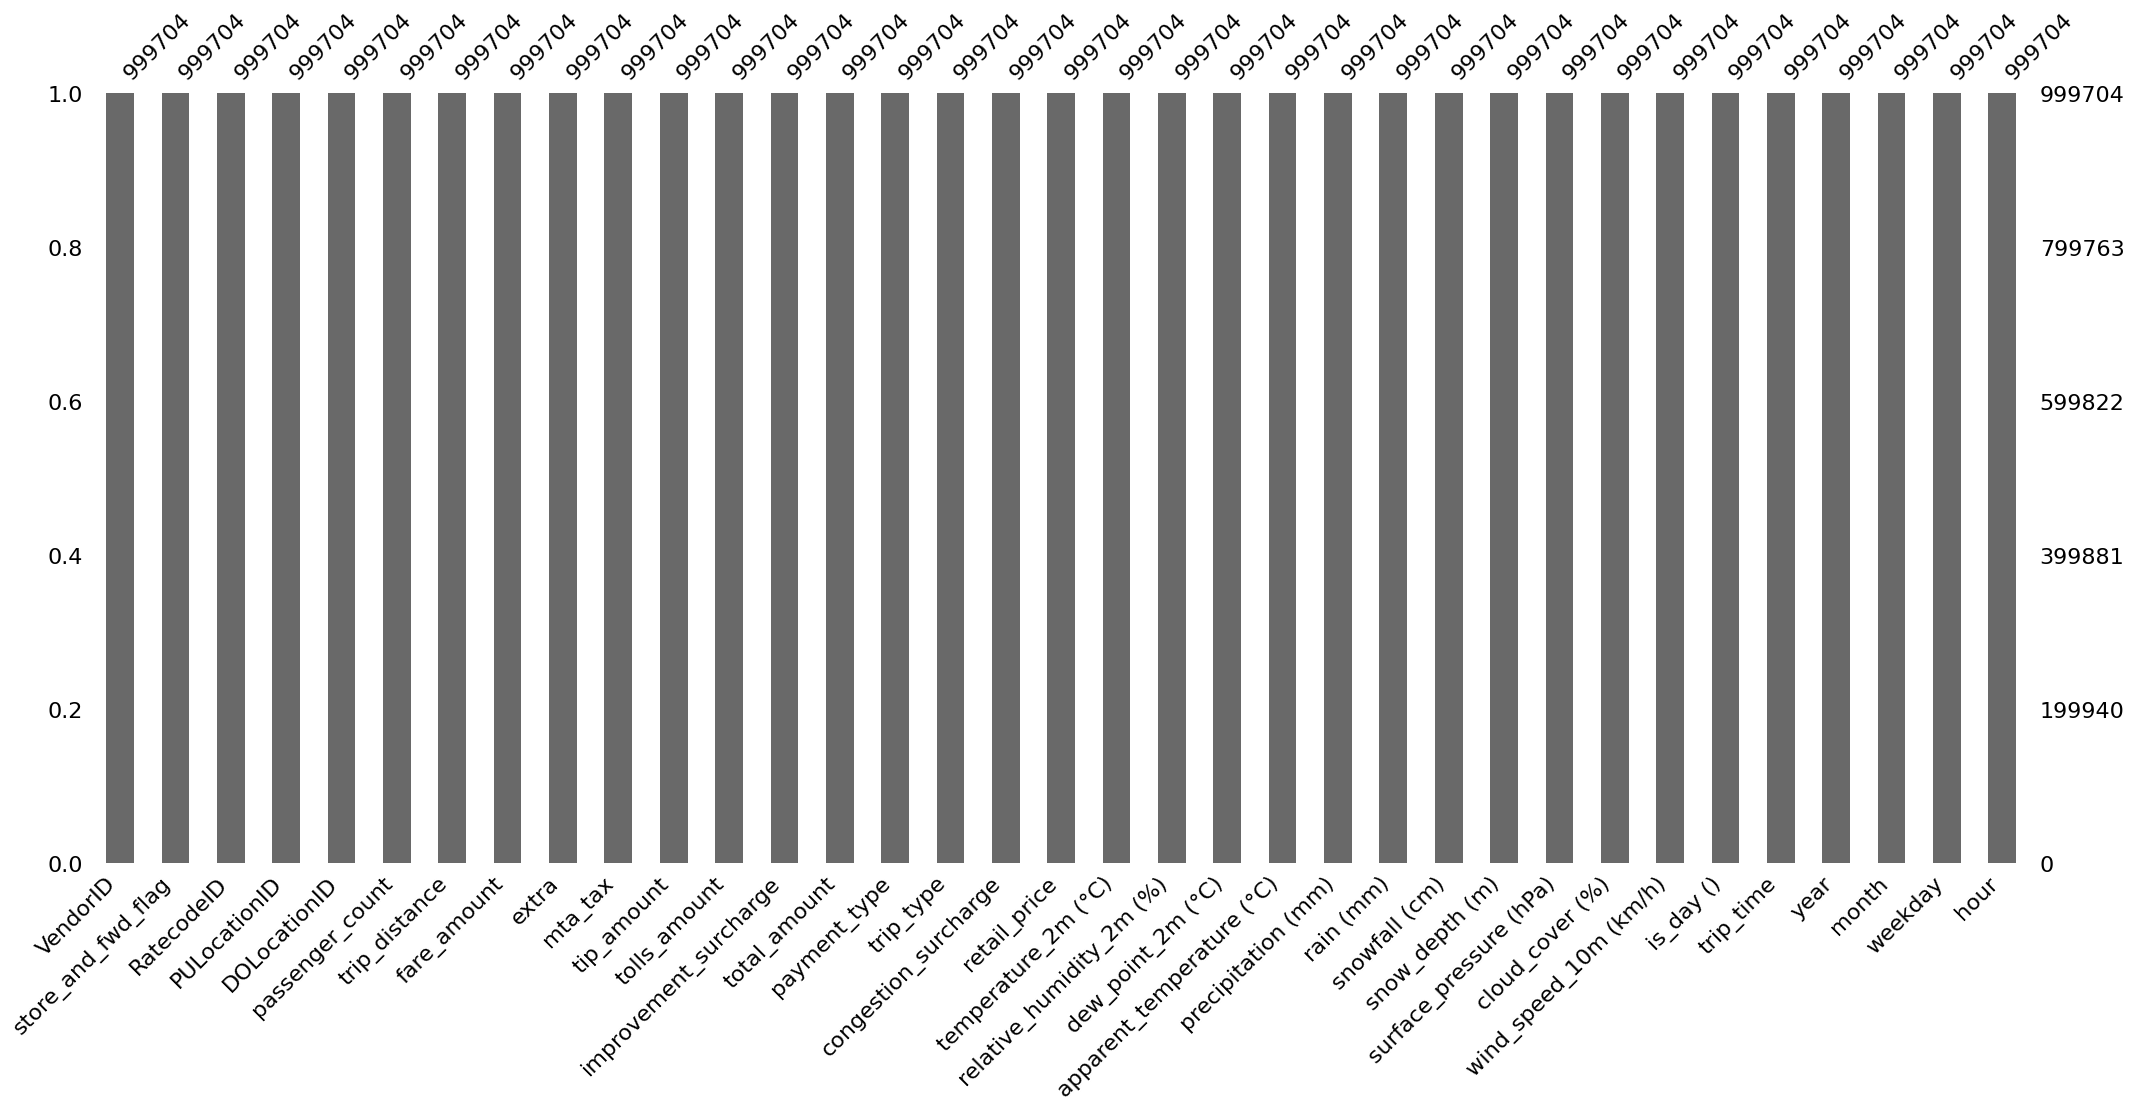

In [11]:
import missingno as msno

msno.bar(train_df)

In [12]:
kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(train_df)

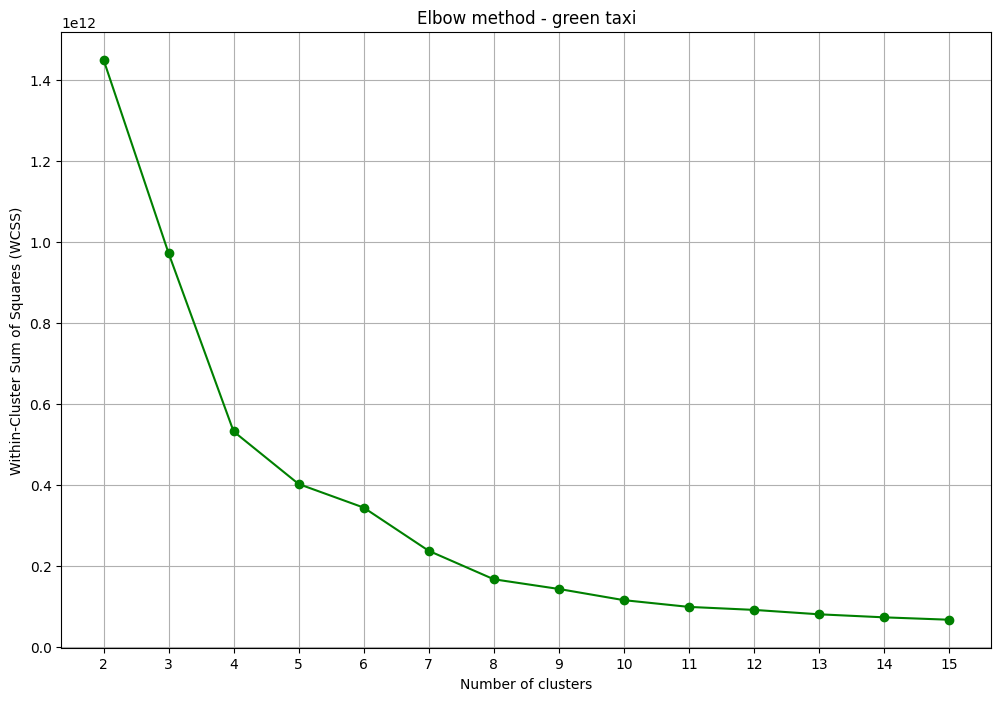

In [20]:
max_clusters = 16

wcss = []
for i in range(2, max_clusters):
    kmeans = KMeans(n_clusters=i, n_init="auto", random_state=42).fit(train_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(12, 8))
plt.plot(range(2, max_clusters), wcss, marker='o', linestyle='-', color='g')
plt.title('Elbow method - green taxi')
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(range(2, max_clusters))
plt.grid(True)
plt.show()

In [12]:
n_samples = 10 ** 4

smaller_train_df = train_df.sample(n_samples)

2 clusters
3 clusters
4 clusters
5 clusters
6 clusters
7 clusters
8 clusters
9 clusters
10 clusters
11 clusters
12 clusters
13 clusters
14 clusters
15 clusters


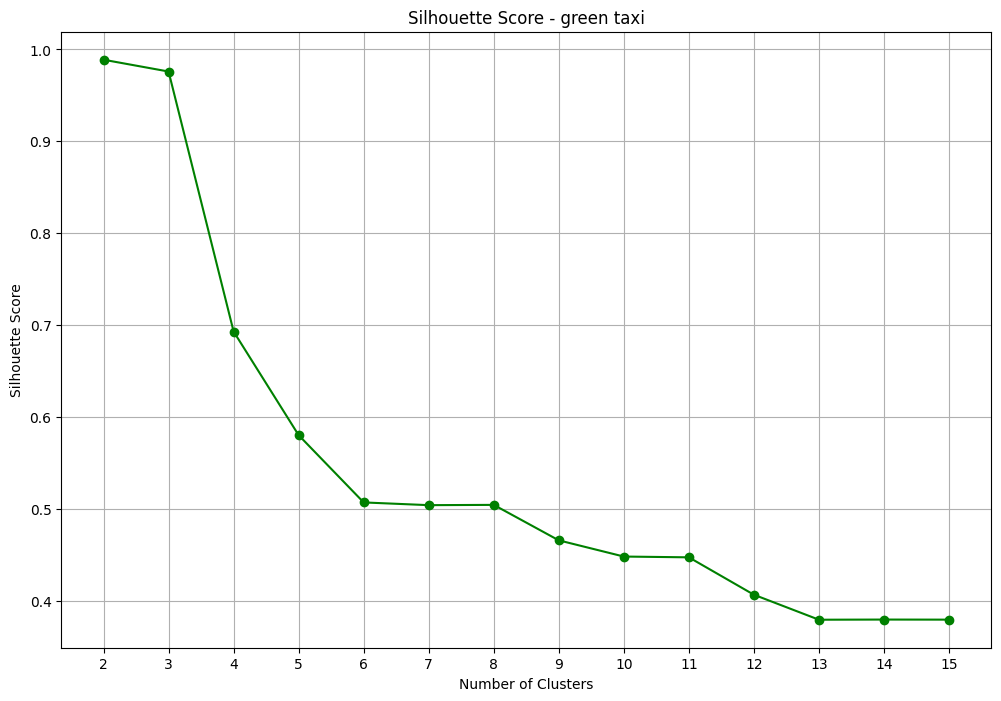

In [27]:
silhouette_scores = []

for i in range(2, max_clusters):
    print(f"{i} clusters")
    kmeans = KMeans(n_clusters=i, n_init="auto", random_state=42)
    cluster_labels = kmeans.fit_predict(smaller_train_df)
    silhouette_avg = silhouette_score(smaller_train_df, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(12, 8))
plt.plot(range(2, max_clusters), silhouette_scores, marker='o', linestyle='-', color='g')
plt.title('Silhouette Score - green taxi')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, max_clusters))
plt.grid(True)
plt.show()

In [16]:
n_samples = 5000

plot_train_df = train_df.sample(n_samples, random_state=42)

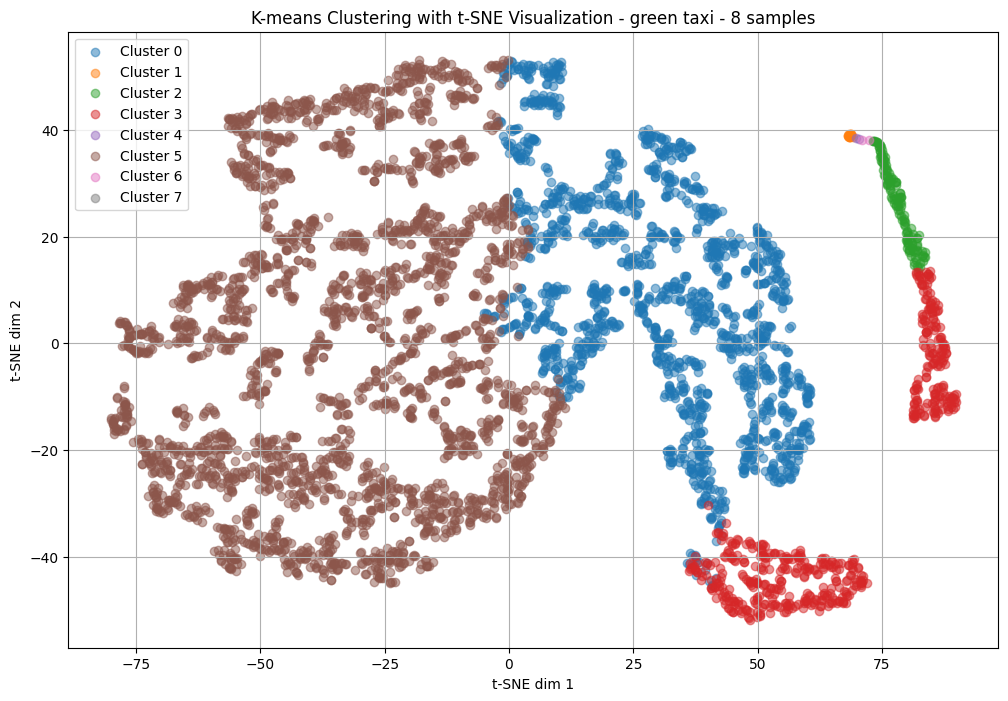

In [22]:
clusters_num = 8

kmeans = KMeans(n_clusters=clusters_num, n_init="auto", random_state=42).fit(train_df)
cluster_labels = kmeans.predict(plot_train_df)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(plot_train_df)

plt.figure(figsize=(12, 8))
for i in range(clusters_num):
    plt.scatter(X_tsne[cluster_labels == i, 0], X_tsne[cluster_labels == i, 1], label=f'Cluster {i}',  alpha=0.5)
    
plt.title(f'K-means Clustering with t-SNE Visualization - green taxi - {clusters_num} clusters')
plt.xlabel('t-SNE dim 1')
plt.ylabel('t-SNE dim 2')
plt.legend()
plt.grid(True)
plt.show()

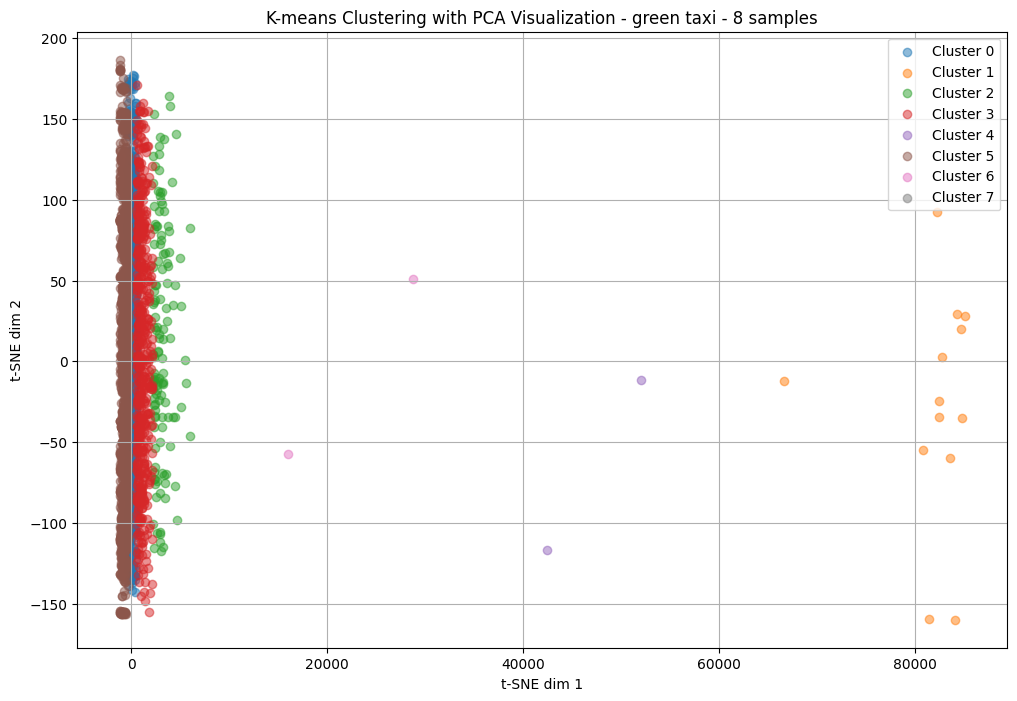

In [23]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(plot_train_df)

plt.figure(figsize=(12, 8))
for i in range(clusters_num):
    plt.scatter(X_pca[cluster_labels == i, 0], X_pca[cluster_labels == i, 1], label=f'Cluster {i}', alpha=0.5)
    
plt.title(f'K-means Clustering with PCA Visualization - green taxi - {clusters_num} clusters')
plt.xlabel('t-SNE dim 1')
plt.ylabel('t-SNE dim 2')
plt.legend()
plt.grid(True)
plt.show()

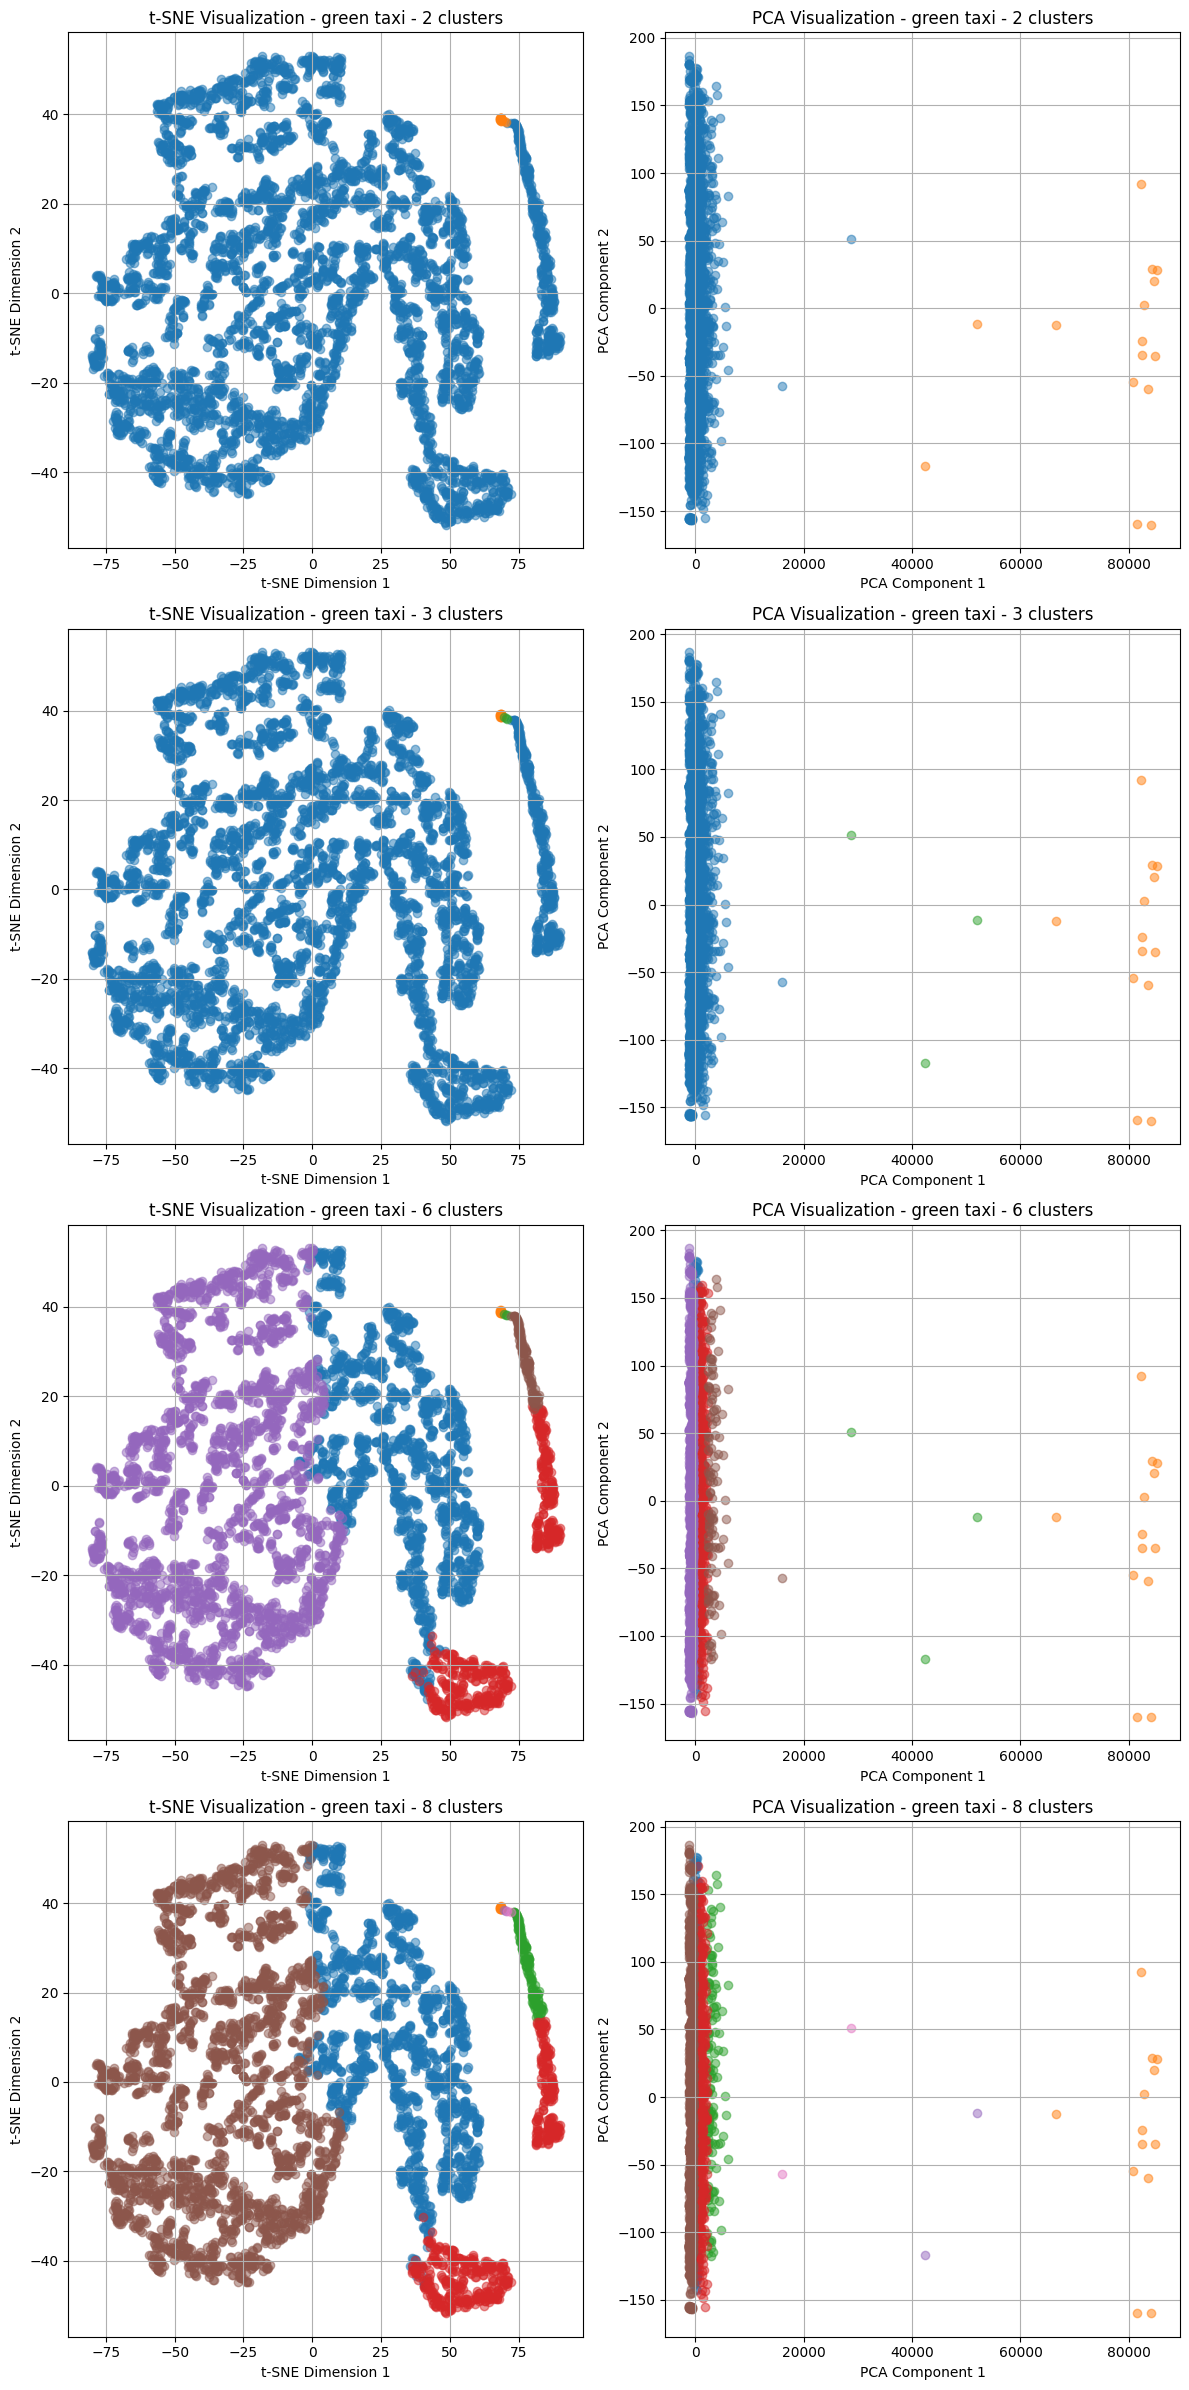

In [31]:
cluster_nums = [2, 3, 6, 8]

fig, axs = plt.subplots(len(cluster_nums), 2, figsize=(12, 24))

for j, clusters_num in enumerate(cluster_nums):
    kmeans = KMeans(n_clusters=clusters_num, n_init="auto", random_state=42).fit(train_df)
    cluster_labels = kmeans.predict(plot_train_df)

    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(plot_train_df)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(plot_train_df)

    axs[j, 0].set_title(f't-SNE Visualization - green taxi - {clusters_num} clusters')
    for i in range(clusters_num):
        axs[j, 0].scatter(X_tsne[cluster_labels == i, 0], X_tsne[cluster_labels == i, 1], label=f'Cluster {i}', alpha=0.5)
    axs[j, 0].set_xlabel('t-SNE Dimension 1')
    axs[j, 0].set_ylabel('t-SNE Dimension 2')
    # axs[j, 0].legend()
    axs[j, 0].grid(True)

    axs[j, 1].set_title(f'PCA Visualization - green taxi - {clusters_num} clusters')
    for i in range(clusters_num):
        axs[j, 1].scatter(X_pca[cluster_labels == i, 0], X_pca[cluster_labels == i, 1], label=f'Cluster {i}', alpha=0.5)
    axs[j, 1].set_xlabel('PCA Component 1')
    axs[j, 1].set_ylabel('PCA Component 2')
    # axs[j, 1].legend()
    axs[j, 1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
#TODO - try also for yellow taxi and fhv 
#TODO - try also other clustering methods (eg. Agglomerative Clustering, DBScan)
#TODO - check what is in outlier values